# Q4

In [97]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import warnings
from scipy.linalg import eig

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# seed np
np.random.seed(5)

In [98]:
##### Step 1: Data Acquisition (Don't change this code)
start_date = "2023-01-01"
end_date = "2025-01-01" # End date is exclusive in some cases, so set it to the start of the next year

data = yf.download("AAPL", start=start_date, end=end_date)
data.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2023-01-03,123.211197,128.954545,122.324571,128.343764,112117500
2023-01-04,124.482040,126.747861,123.221065,125.004162,89113600
2023-01-05,123.161942,125.871071,122.905811,125.240583,80962700
2023-01-06,127.693626,128.353667,123.033926,124.137284,87754700
2023-01-09,128.215714,131.427273,127.959583,128.530965,70790800


In [99]:
##### Step 2: Preprocess Data and Assign States


def compute_daily_returns(df):
    # Use percentage change of the adjusted close (or Close)
    returns = df['Close'].pct_change().dropna()
    returns.name = 'ret'
    return returns

# Calculate daily returns
data['Return'] = compute_daily_returns(data)
data.dropna(inplace=True) # to remove Nan values

# Define 5 states based on quantiles e.g [0.2, 0.4, 0.6, 0.8]
n_states = 5 # number of states
qs = [i / n_states for i in range(1, n_states)]
quantiles = data['Return'].quantile(qs).values
state_names = ["Very Bearish", "Bearish", "Neutral", "Bullish", "Very Bullish"]

# Use pandas.cut to assign bins; include lowest to catch equal values
bins = np.concatenate(([-np.inf], quantiles, [np.inf]))
data['State'] =  pd.cut(data['Return'], bins=bins, labels=state_names, include_lowest=True) #column that provides the 5 differen states "Very Bearish", "Bearish", "Neutral", "Bullish", "Very Bullish" coded as numbers from 0 to 4

# Store return distributions for each state (needed at step 5)
return_distributions = []
for i in range(5):
    return_distributions.append(data[data['State'] == state_names[i]]['Return'].values)


print("\nData with States:")
data.tail()



Data with States:


Price,Close,High,Low,Open,Volume,Return,State
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,
2024-12-24,257.037476,257.047410,254.140559,254.339671,23234700,0.011478,Bullish
2024-12-26,257.853760,258.928914,256.470034,257.027510,27237100,0.003176,Neutral
2024-12-27,254.439224,257.535238,251.920617,256.669129,42355300,-0.013242,Very Bearish
2024-12-30,251.064499,252.358649,249.621030,251.094363,35557500,-0.013263,Very Bearish
2024-12-31,249.292526,252.139650,248.306978,251.303436,39480700,-0.007058,Bearish


In [100]:
##### Step 3: Construct Transition Matrix

def build_transition_matrix(states, n_states=5):
    counts = np.zeros((n_states, n_states), dtype=float)
    s = states.values
    for i in range(len(s)-1):
        index_a = state_names.index(s[i])
        index_b = state_names.index(s[i+1])
        counts[index_a, index_b] += 1
    # Handle rows with zero transitions by assigning a small uniform probability
    row_sums = counts.sum(axis=1, keepdims=True)
    with np.errstate(invalid='ignore'):
        P = np.divide(counts, row_sums, where=row_sums!=0)
    # Replace NaN rows (no outgoing observed transitions) with uniform
    for i in range(n_states):
        if row_sums[i,0] == 0:
            P[i,:] = 1.0 / n_states
    return P, counts


P, counts = build_transition_matrix(states=data['State'],n_states=n_states)
print("\nTransition Matrix (P):")

print("\n\n")

print(tabulate(P,tablefmt="plain"))

print("\n\n")



Transition Matrix (P):



0.207921  0.247525  0.188119  0.188119  0.168317
0.232323  0.151515  0.20202   0.181818  0.232323
0.15      0.2       0.21      0.22      0.22
0.24      0.25      0.17      0.16      0.18
0.18      0.15      0.23      0.24      0.2





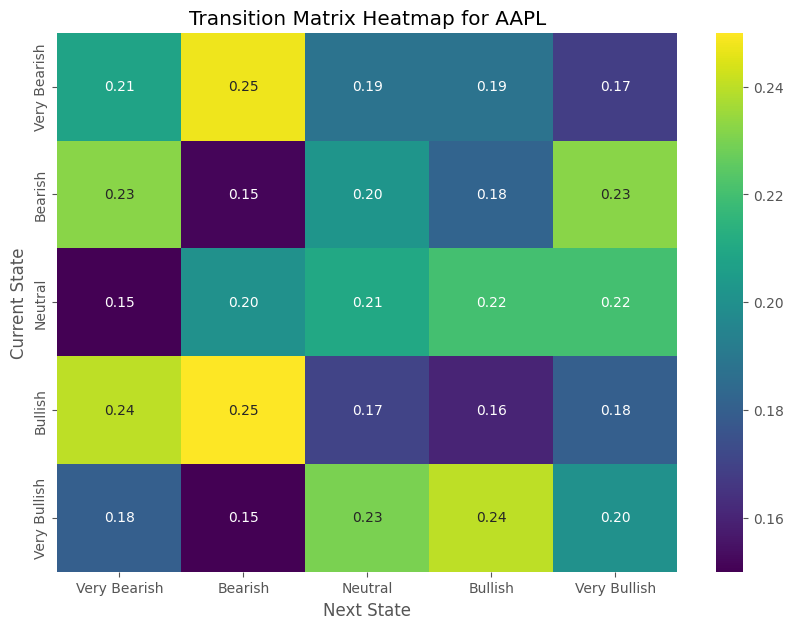


Stationary Distribution (pi):
Very Bearish    0.201975
Bearish         0.199809
Neutral         0.200066
Bullish         0.198051
Very Bullish    0.200100
dtype: float64

Interpretation: ---------------------

Mean Return Time (in days):
Very Bearish    4.951108
Bearish         5.004788
Neutral         4.998349
Bullish         5.049212
Very Bullish    4.997512
dtype: float64


In [101]:
##### Step 4: Analyze Markov Chain Properties

# Visualize as heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(P, annot=True, fmt='.2f', cmap='viridis',
            xticklabels=state_names, yticklabels=state_names)
plt.title(f'Transition Matrix Heatmap for AAPL')
plt.xlabel('Next State')
plt.ylabel('Current State')
plt.show()

def stationary_distribution(P):
    # Solve pi = pi P 
    w, v = eig(P.T)
    # find eigenvalue closest to 1
    idx = np.argmin(np.abs(w - 1.0))
    pi = np.real(v[:, idx])
    pi = pi / pi.sum()
    # ensure non-negative
    pi = np.real_if_close(pi)
    pi = np.maximum(pi, 0)
    pi = pi / pi.sum()
    return pi

# Calculate stationary distribution
# We solve pi = pi * P, which is (P.T - I) * pi.T = 0
# This is an eigenvector problem. We find the eigenvector of P.T for eigenvalue 1.
pi = stationary_distribution(P)
pi = pi.flatten().real # Get 1D array if you haven't done already.

print("\nStationary Distribution (pi):")
pi_series = pd.Series(pi, index=state_names)
print(pi_series)
print("\nInterpretation: ---------------------") # TODO

# Calculate mean return time
mean_return_time = 1.0 / pi
print("\nMean Return Time (in days):")
mrt_series = pd.Series(mean_return_time, index=state_names)
print(mrt_series)


In [102]:
##### Step 5: Simulate Future Stock Prices

def simulate_prices(start_price, n_days, P, return_dists):
    prices = [start_price]
    # Start from the last known state
    current_state = state_names.index(data['State'].iloc[-1])
    
    for _ in range(n_days):

      # 1. Predict next state using transition probabilities
      next_state = np.random.choice([0,1,2,3,4], p=P[current_state])

      # 2. Sample a return from that state's empirical distribution
      rets = return_dists[next_state]
      if rets is None or len(rets)==0:
            # fallback to small near-zero return
          sampled_return = 0.0
      else:
          sampled_return = np.random.choice(rets)

      # 3. Calculate next price
      next_price = prices[-1] * (1 + sampled_return)
      prices.append(next_price) # save price

      # 4. Update current state
      current_state = next_state


    return prices

# Run 1,000 simulations
n_simulations = 1000
n_forecast_days = 100 #
last_price = data['Close'].iloc[-1]['AAPL']
print(last_price)
simulations = []


for _ in range(n_simulations):
    simulations.append(simulate_prices(last_price, n_forecast_days, P, return_distributions))

simulations_df = pd.DataFrame(simulations).T
simulations_df.columns = [f'Sim {i+1}' for i in range(n_simulations)]

simulations_df

249.2925262451172


,Sim 1,Sim 2,Sim 3,Sim 4,Sim 5,Sim 6,Sim 7,Sim 8,Sim 9,Sim 10,...,Sim 991,Sim 992,Sim 993,Sim 994,Sim 995,Sim 996,Sim 997,Sim 998,Sim 999,Sim 1000
0,249.292526,249.292526,249.292526,249.292526,249.292526,249.292526,249.292526,249.292526,249.292526,249.292526,...,249.292526,249.292526,249.292526,249.292526,249.292526,249.292526,249.292526,249.292526,249.292526,249.292526
1,247.223314,245.574448,251.863817,252.352955,249.437397,244.494716,246.726639,250.014531,251.399295,243.929517,...,252.895001,249.292526,245.678629,248.072350,247.467308,248.456851,249.481414,252.360160,252.982852,248.869553
2,244.890561,247.686241,253.146014,252.145295,250.091318,245.417666,247.649792,250.395993,248.351701,246.135167,...,256.851332,253.147821,254.057156,250.631056,242.961044,250.109928,247.710968,251.480957,250.149361,248.013954
3,259.538984,249.782493,247.947704,253.426262,249.663313,248.788727,249.883836,254.273032,246.891811,251.319554,...,258.010650,252.963813,253.524628,251.327438,243.393085,248.359417,249.294285,249.191581,250.016666,251.383277
4,261.834907,250.396047,249.055583,256.508753,248.117583,246.150388,253.237856,252.555793,248.247516,250.591410,...,261.805745,251.001749,258.877092,255.648501,240.980243,249.829342,248.095259,247.774425,245.463979,249.905566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,276.319457,282.993672,303.619058,369.088350,281.143356,322.220861,311.032767,313.917133,368.761690,286.196281,...,297.903129,263.659499,326.994461,276.837526,286.612968,315.617831,291.239322,254.795750,271.691112,240.325582
97,276.511220,282.254631,300.283937,372.675732,278.583037,320.479276,321.640106,308.561516,376.886300,284.029434,...,301.560324,268.062193,329.551847,269.592516,288.511087,334.496890,292.800385,247.469256,269.349472,239.026635
98,279.905799,287.531044,298.524292,377.261640,277.273531,315.913641,322.244333,306.806722,382.954597,282.041522,...,301.346858,267.643922,325.556848,269.996586,288.826888,334.760258,293.436523,246.616103,268.446562,240.919782
99,274.865937,286.899451,297.043840,377.061518,273.361402,315.245794,320.478208,309.028772,386.395696,277.835008,...,306.993670,266.542876,328.075611,271.136001,287.184325,336.329737,292.490864,245.216477,263.250091,236.306710


In [103]:

##### Step 6: Backtest Model Predictions
# Note: A true rolling window backtest is computationally intensive.
# This is a simplified version for demonstration.
# A full backtest would re-calculate P and return_dists at each step.

def backtest_model(historical_data, window_size, n_sims=100):
    predictions = []
    actuals = []
    lower_ci = []
    upper_ci = []

    prices = historical_data['Close']
    states = historical_data['State']

    # Start after the first rolling window
    for t in range(window_size, len(historical_data)):

        # 1. Rolling window (not used for recalculating P in this simplified version)
        window_data = historical_data.iloc[t - window_size : t]

        # We use global P and return_dists for simplicity.
        current_state = state_names.index(states.iloc[t-1])
        current_price = prices.iloc[t-1]

        # 3. Simulate next-day price n_sims times
        sim_next_prices = []
        for _ in range(n_sims):
            # Predict next state
            next_state = np.random.choice([0,1,2,3,4], p=P[current_state])

            # Sample return and compute next price
            rets = return_distributions[next_state]
            if rets is None or len(rets)==0:
                # fallback to small near-zero return
              sampled_return = 0.0
            else:
             sampled_return = np.random.choice(rets)
               
            sim_price = current_price * (1 + sampled_return)
            sim_next_prices.append(sim_price)

        sim_next_prices = np.array(sim_next_prices)

        # 4. Calculate stats (mean + 95% CI)
        pred_mean = sim_next_prices.mean()
        ci_low = np.percentile(sim_next_prices, 2.5)
        ci_high = np.percentile(sim_next_prices, 97.5)

        predictions.append(pred_mean)
        lower_ci.append(ci_low)
        upper_ci.append(ci_high)

        # actual next-day close
        actuals.append(prices.iloc[t]["AAPL"])

    backtest_df = pd.DataFrame({
        'Actual': actuals,
        'Predicted': predictions,
        'Lower_CI': lower_ci,
        'Upper_CI': upper_ci
    }, index=historical_data.index[window_size:])

    return backtest_df


# Run backtest (e.g., on last 100 days with a 150-day window)
backtest_window = 150
backtest_data = data.iloc[-250:] # Use last ~year of data
backtest_results = backtest_model(backtest_data, backtest_window)

backtest_results


,Actual,Predicted,Lower_CI,Upper_CI
Date,,,,
2024-08-09,214.781250,212.038999,205.755285,218.449146
2024-08-12,216.312622,215.723424,208.773331,221.776825
2024-08-13,220.031677,216.066406,210.048709,221.943916
2024-08-14,220.479172,220.561972,214.563249,225.376897
2024-08-15,223.462372,221.426976,216.610017,229.322107
...,...,...,...,...
2024-12-24,257.037476,255.220269,249.130350,261.665081
2024-12-26,257.853760,257.599756,252.230335,264.981743
2024-12-27,254.439224,258.271584,253.364654,263.345120


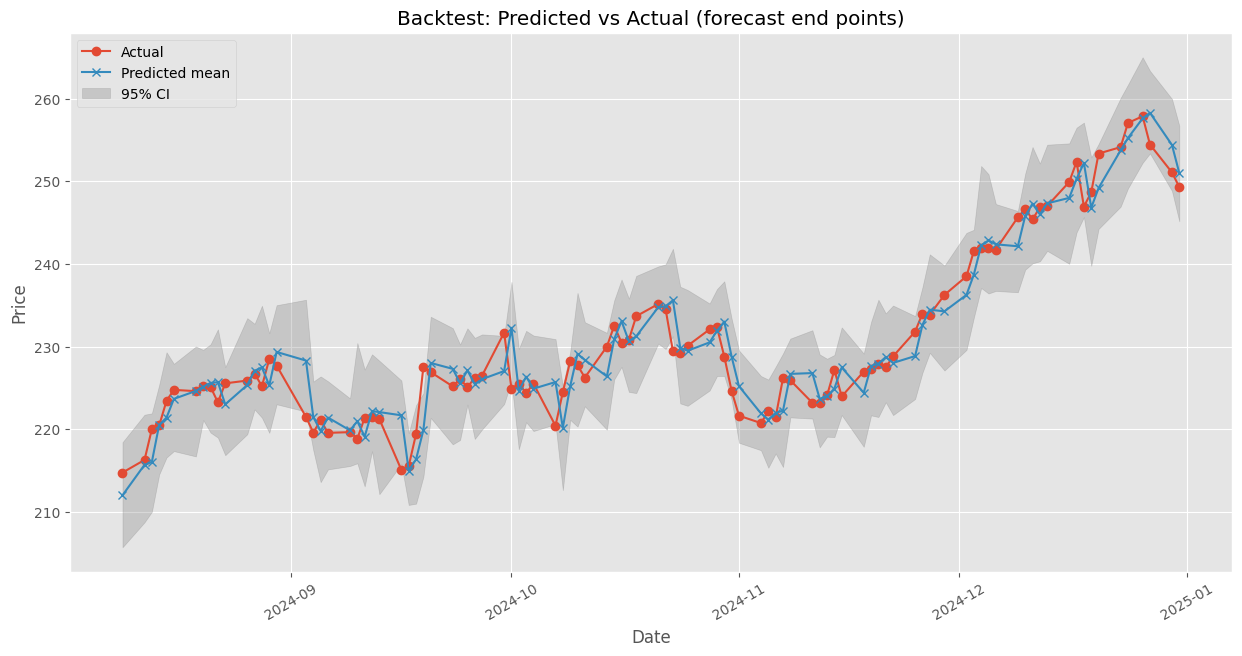

In [104]:
##### Step 7: Visualize and Interpret Results
# Plot 1: Backtesting Results

n_sim = n_simulations
n_days = n_forecast_days

plt.figure(figsize=(15, 7))

ax = plt.gca()
x = backtest_results.index
ax.plot(x, backtest_results['Actual'], label='Actual', marker='o')
ax.plot(x, backtest_results['Predicted'], label='Predicted mean', marker='x')
ax.fill_between(x, backtest_results['Lower_CI'], backtest_results['Upper_CI'], color='gray', alpha=0.3, label='95% CI')
ax.set_title('Backtest: Predicted vs Actual (forecast end points)')
ax.set_ylabel('Price')
ax.set_xlabel('Date')
ax.legend()
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

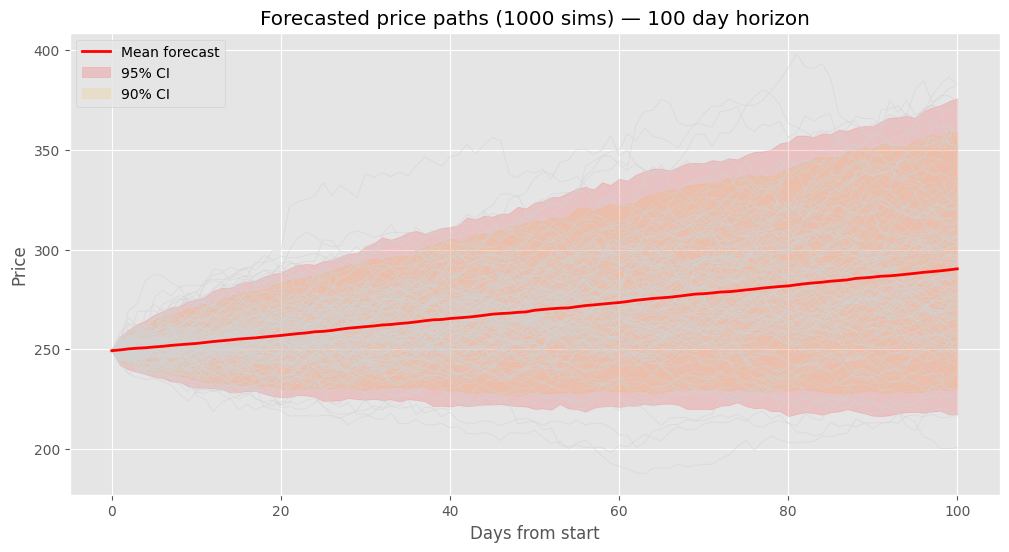

In [105]:

# Plot 2: Future Forecast
sims_arr = np.array(simulations)

days = np.arange(n_days+1)
mean_path = np.mean(sims_arr, axis=0)
lower_95 = np.percentile(sims_arr, 2.5, axis=0)
upper_95 = np.percentile(sims_arr, 97.5, axis=0)
lower_90 = np.percentile(sims_arr, 5, axis=0)
upper_90 = np.percentile(sims_arr, 95, axis=0)

plt.figure(figsize=(12,6))
# plot subset of individual sims for context (light gray)
n_plot = min(150, n_sim)
for i in range(n_plot):
    plt.plot(days, sims_arr[i], color='lightgray', linewidth=0.6, alpha=0.6)
plt.plot(days, mean_path, color='red', label='Mean forecast', linewidth=2)
plt.fill_between(days, lower_95, upper_95, color='red', alpha=0.15, label='95% CI')
plt.fill_between(days, lower_90, upper_90, color='orange', alpha=0.12, label='90% CI')
plt.xlabel('Days from start')
plt.ylabel('Price')
plt.title(f'Forecasted price paths ({n_sim} sims) — {n_days} day horizon')
plt.legend()
plt.grid(True)
plt.show()


In [106]:
##### Step 8: Generate Summary Statistics
final_day_prices = simulations_df.iloc[-1]

current_price = data['Close'].iloc[-1]['AAPL']
predicted_mean_final = final_day_prices.mean()
avg_predicted_price_over_period = sims_arr.mean()  # average across sims and days
avg_predicted_price_over_period = float(avg_predicted_price_over_period)
pred_min = float(final_day_prices.min())
pred_max = float(final_day_prices.max())

#print(return_distributions)
returns = [item for sublist in return_distributions for item in sublist]
hist_vol_daily = np.std(returns, ddof=1) 
hist_vol_annual = hist_vol_daily * np.sqrt(252) #252 trading days on average per year

# Simulated volatility: compute daily log returns across sims, then annualize using pooled returns
# compute returns for each sim path (n_sim x n_days)
sim_daily_rets = (sims_arr[:, 1:] / sims_arr[:, :-1]) - 1.0  # shape n_sim x n_days
# flatten to get distribution of simulated daily returns
sim_daily_rets_flat = sim_daily_rets.flatten()
sim_vol_daily = np.std(sim_daily_rets_flat, ddof=1)
sim_vol_annual = sim_vol_daily * np.sqrt(252)

# Confidence intervals for final predicted price
ci90_lower = np.percentile(final_day_prices, 5)
ci90_upper = np.percentile(final_day_prices, 95)
ci95_lower = np.percentile(final_day_prices, 2.5)
ci95_upper = np.percentile(final_day_prices, 97.5)

summary_table = [
    ['Current Price', f"{current_price:.2f}"],
    ['Predicted Price after {0} days (mean)'.format(n_days), f"{predicted_mean_final:.2f}"],
    ['Average predicted price (all simulations, all days)', f"{avg_predicted_price_over_period:.2f}"],
    ['Prediction range (min final)', f"{pred_min:.2f}"],
    ['Prediction range (max final)', f"{pred_max:.2f}"],
    ['Historical Volatility', f"{hist_vol_annual:.3%}"],
    ['Simulated Volatility', f"{sim_vol_annual:.3%}"],
    ['90% CI final price', f"[{ci90_lower:.2f}, {ci90_upper:.2f}]"],
    ['95% CI final price', f"[{ci95_lower:.2f}, {ci95_upper:.2f}]"]
]

print("Summary statistics (simulation):\n\n")
print(tabulate(summary_table, headers=['Metric','Value'], tablefmt='github'))
print("\n\n")





Summary statistics (simulation):


| Metric                                              | Value            |
|-----------------------------------------------------|------------------|
| Current Price                                       | 249.29           |
| Predicted Price after 100 days (mean)               | 290.34           |
| Average predicted price (all simulations, all days) | 269.53           |
| Prediction range (min final)                        | 190.71           |
| Prediction range (max final)                        | 409.15           |
| Historical Volatility                               | 21.354%          |
| Simulated Volatility                                | 21.352%          |
| 90% CI final price                                  | [230.47, 358.94] |
| 95% CI final price                                  | [217.32, 375.85] |





In [107]:
##### Step 9: Evaluate Model Performance
# select last up to 21 rows as we have about 21 trading days
last_month = backtest_results.tail(21)
mae = np.mean(np.abs(last_month['Predicted'] - last_month['Actual']))
mape = np.mean(np.abs((last_month['Predicted'] - last_month['Actual']) / last_month['Actual'])) * 100.0
coverage_95 = np.mean((last_month['Actual'] >= last_month['Lower_CI']) & (last_month['Actual'] <= last_month['Upper_CI']))
coverage_95_pct = coverage_95 * 100.0
eval_table = [
    ['Windows evaluated', len(last_month)],
    ['MAE (mean absolute error)', f"{mae:.2f}"],
    ['MAPE (mean abs pct error)', f"{mape:.2f}%"],
    ['Coverage of actuals by 95% CI', f"{coverage_95_pct:.2f}%"]
]
print("\nBacktest evaluation (last ~21 windows):")
print(tabulate(eval_table, headers=['Metric','Value'], tablefmt='github'))


print(f"""
Discussion:
-----------------------------------------
Comparison of Simulated Forecasts vs. Actual Prices (Last Month)

We can see that over the final 21 trading days (last month), the Markov chain model performs reasonably well:

    - MAE = 1.95: On average, the forecast deviates by less than $2 from the true price which is a quite small deviation relative to a $250 stock.

    - MAPE = 0.78%: the percentage error is below 1%, suggesting high short-term accuracy.

    - 95% confidence interval coverage of 100%: all actual prices fell inside the model's 95% CI band which indicates good uncertainty calibration, 
    meaning the model does not underestimate volatility.

Overall, the Markov chain approach demonstrates strong forecasting consistency for short horizons. The model's transition probabilities
derived from historical returns seem to capture local price dynamics well enough for near-term forecasts.


Reliability and Practical Insights from the Simulation

The Markov chain simulation predicted a positive expected price variation (Current: 249.29 and predicted: 290.34) consistent with the historical return distributions.

For long-horizon outcomes, the simulation shows a widely spread range of possible future prices (190.71 to 409.15) with confidence intervals :

    - 90% CI: [230.47, 358.94]

    - 95% CI: [217.32, 375.85]
This indicates uncertainty which is a realistic feature of financial markets.

In addition, the Markov chain accurately preserves the empirical variability of returns since the annual simulated and historical volatility are nearly the same (21.352% and 21.354%).

Overall, the Markov chain shows a good near-term predictive power with low MAE and MAPE, a statistically reliable confidence intervals covering all realized prices and reasonable 
medium-term projections, though with wide uncertainty, reflecting the limitations of purely historical, memoryless models.

However, some limitations of the model include the fact that Markov chains assume returns depend only on the current state, ignoring other important factors such as structural breaks. Also,for horizons beyond a few weeks, forecasts become dominated by volatility rather and loose accuracy.


-----------------------------------------
""")


Backtest evaluation (last ~21 windows):
| Metric                        | Value   |
|-------------------------------|---------|
| Windows evaluated             | 21      |
| MAE (mean absolute error)     | 1.95    |
| MAPE (mean abs pct error)     | 0.78%   |
| Coverage of actuals by 95% CI | 100.00% |

Discussion:
-----------------------------------------
Comparison of Simulated Forecasts vs. Actual Prices (Last Month)

We can see that over the final 21 trading days (last month), the Markov chain model performs reasonably well:

    - MAE = 1.95: On average, the forecast deviates by less than $2 from the true price which is a quite small deviation relative to a $250 stock.

    - MAPE = 0.78%: the percentage error is below 1%, suggesting high short-term accuracy.

    - 95% confidence interval coverage of 100%: all actual prices fell inside the model's 95% CI band which indicates good uncertainty calibration, 
    meaning the model does not underestimate volatility.

Overall, the Mar